In [1]:
import numpy as np
import os
import re
from Corrfunc.utils import convert_rp_pi_counts_to_wp
from Corrfunc.theory import DDrppi

calculate the wp

In [2]:
import pickle
with open('c_s_pair_count.bin', 'rb') as f:
    result_dict = pickle.load(f)
calc = result_dict[(1,1)]
vol = np.pi*(calc['rmax']**2 - calc['rmin']**2)*1           # delta r pi = 1

In [3]:
boxsize = 2500
NR = 1000_000_000
n = NR / (boxsize**3)
RR = calc.copy()
RR['npairs'] = (NR*vol*n*2).astype('uint64')            # this has been cross checked to be correct

In [4]:
NDs = np.load('halo_mass_function.npy')['count']
logMh_N = len(NDs)

In [5]:
pimax = 100
Nbins = len(RR['npairs'])//pimax

## Important
The M_i M_i pair count will have 1h term, so it should be excluded.

In [6]:
halos = np.load('main_halo_zspace.npy')
halo_s = np.load('satellite_halo_zspace.npy')

In [8]:
sep_min = 0.1
sep_max = 100
sep_N = 30

pimax = 100                         # this should match the result from auto corr
boxsize = 2500

r_pbins = np.geomspace(sep_min, sep_max, sep_N+1)

In [7]:
logMh_m = 11.5
logMh_M = 14.72
logMh_bin = 0.02
logMh_N = int((logMh_M - logMh_m) / logMh_bin)

bins = np.arange(logMh_N+1) * logMh_bin + logMh_m
res = np.digitize(np.log10(halos['M_h']), bins)

In [11]:
nthread = 40
for i in range(logMh_N):
    halo1 = halos[res == i+1]
    halo2 = halo_s[res == i+1]
    one_h_term = DDrppi(0, nthread, pimax, r_pbins, X1=[boxsize/2], Y1=[boxsize/2], Z1=[boxsize/2], 
                                X2=halo2['X'] - halo1['X'] + boxsize/2, 
                                Y2=halo2['Y'] - halo1['Y'] + boxsize/2, 
                                Z2=halo2['Z'] - halo1['Z'] + boxsize/2, 
                                periodic=True, boxsize=boxsize, verbose=False)
    result_dict[(i+1, i+1)]['npairs'] -= one_h_term['npairs']

In [12]:
wp_array = np.zeros((logMh_N, logMh_N, Nbins))
cnt = 0
for i in range(logMh_N):
    for j in range(logMh_N):
        if (i+1,j+1) not in result_dict:
            print(i,j)
            continue
        ND1 = NDs[i]
        ND2 = NDs[j]
        D1R2 = RR.copy()
        D1R2['npairs'] = ND1*vol*n*2
        D2R1 = RR.copy()
        D2R1['npairs'] = ND2*vol*n*2
        R1R2 = RR
        D1D2 = result_dict[(i+1,j+1)]
        wp_array[i,j] = convert_rp_pi_counts_to_wp(ND1, ND2, NR, NR, D1D2, D1R2, D2R1, R1R2, pimax=pimax, nrpbins=Nbins)

In [13]:
np.save('2h_cs_wp', wp_array)

In [14]:
wp_array.shape

(161, 161, 30)

check the result

In [17]:
sep_min = 0.1
sep_max = 100
sep_N = 30
r_pbins = np.geomspace(sep_min, sep_max, sep_N+1)
r_p = (r_pbins[1:]*r_pbins[:-1])**0.5

In [18]:
import matplotlib.pyplot as plt

[]

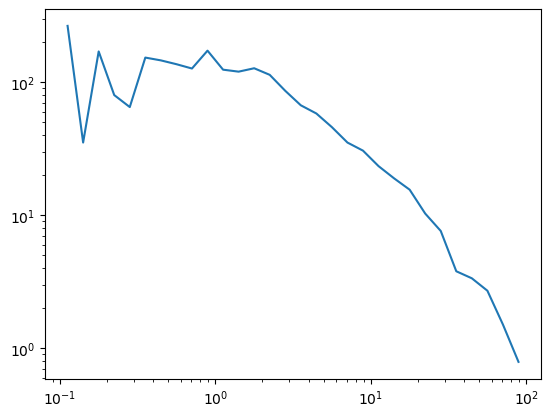

In [22]:
plt.plot(r_p, wp_array[80, 80])
plt.loglog()